# Gesture Recognition
### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each video is a sequence of 30 frames of image and each gesture corresponds to a below specific command:

- **Thumbs Up**   : Increase the volume.
- **Thumbs Down** : Decrease the volume.
- **Left Swipe**  : Slide the videos backward.
- **Right Swipe** : Slide the videos forward.
- **Stop**        : Stop the video.


 
### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

#### In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

Authors:
* Sidhartha Mahapatro
* S S B Phani Pradeep Miriyala

In [1]:
# Display GPU information on VM.
!nvidia-smi

Thu Feb  4 11:47:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    65W / 149W |      0MiB / 11441MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# Importing warnings to ignore warnings.
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Importing image libraries
import numpy as np
from scipy.misc import imread, imresize
from PIL import Image
import cv2
# Importing OS library to parse paths of images.
import os
# To create dynamic model files from 
import datetime
# Importing randomg library for setting the seed before building models.
import random as rn

In [5]:
# Defining project folder where all images are stored.
project_folder='Project_data'

In [ ]:
# Define a dictionary object to store all models.
# All models will be stored in a dictionary with key being the model name.
models = {}

# Generator
A generator class will be used to generate training data and validation data for use tensorflow models. The generator will yield the data per the current batch.

The generator will 
- Read in images as specified by indices of frames to be used for training and validation
- Performs image normalization and augmentation in two levels.
- A level 1 augmentation does warp affine with angle of 10 degrees.
- A level 2 augmentation does warp affine and image rotation by 10 degrees.

In [6]:
class Generator:
    '''Generator class for creating objects to use with Keras Sequential model'''
    def __init__(self, root_folder, gen_type, frames_list, batch_size=5, image_height=160, image_width=160, 
                 augment_level=0):
        ''' 
        Constructor for the class.
        root_folder is root folder where training and validation data are stored as sub-folders.
        gen_type is type of generator. It can be either "train" or "val". Any other values are not supported.
        frames_list is list of frame indices from each video.
        batch_size is size of batch to be used for training and validation.
        image_height is desired height of image for model.
        image_width is desired width of image for model.
        num_classes is number of classes for training.
        augment_level is level of augmentation needed. 
                    Level 0 - No augmentation,
                    Level 1 - Augmentation with wrap affine transformation
                    Level 2 - Augmentation with wrap affine transformation and rotation of image.
        '''
        if gen_type == 'train':
            self.src_path = os.path.join(root_folder,'train')
            self.csv_file = os.path.join(root_folder,'train.csv')
        elif gen_type == 'val':
            self.src_path = os.path.join(root_folder,'val')
            self.csv_file = os.path.join(root_folder,'val.csv')
        
        self.folders = np.random.permutation(open(self.csv_file).readlines())        
        self.num_sequences = len(self.folders)
        self.num_channels = 3 # All images are RGB.
        self.batch_size = batch_size
        self.num_batches = self.num_sequences//self.batch_size
        
        self.image_height = image_height
        self.image_width = image_width
        self.num_classes = 5
        
        self.frames_list = frames_list
        self.total_frames = len(self.frames_list)
        self.augment_level = augment_level
        self.steps = self.__get_steps()
        
    def __get_steps(self):
        '''
        Get number of steps required based on batch size of object.
        '''
        if self.num_sequences%self.batch_size==0:
            return self.num_sequences//self.batch_size
        else:
            return 1 + (self.num_sequences//self.batch_size)
        
    def __apply_augmentation(self,frame):
        '''
        Apply augmentation on image frame. 
        Augmentation applied is based on level of augmentation set during initialization of object.
        '''
        ang = 10
        rang = 10
        if self.augment_level<1: 
            return None
        # Horizontal or Vertical flipping can't be applied.
        # Both flippings will negatively impact training data and corresponding labels.
        shifted = cv2.warpAffine(frame, np.float32([[1, 0, np.random.randint(-ang,ang)],
                                                    [0, 1, np.random.randint(-ang,ang)]]), 
                                 (frame.shape[1], frame.shape[0]))
        # Converting/shifting to Gray Scale Image form RGB
        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
        # Setting up the co-ordinate
        x0, y0 = np.argwhere(gray > 0).min(axis=0)
        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
        # cropping the images to have the targeted gestures and remove the noise from the images.
        cropped = shifted[x0:x1,y0:y1,:]
        image_resized = imresize(cropped,(self.image_height,self.image_width,3))
        if self.augment_level>1:
            # Configuring 2D matrix for ration matrix
            M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                        np.random.randint(-rang,rang), 1.0)
            # Rotating the image using warpAffine method based on rotation matrix
            image_resized = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
        image_resized[:,:,0] = image_resized[:,:,0]/255
        image_resized[:,:,1] = image_resized[:,:,1]/255
        image_resized[:,:,2] = image_resized[:,:,2]/255
        return image_resized[:,:,0],image_resized[:,:,1],image_resized[:,:,2]
        
    def __gen_batch_data(self, batch):
        '''
        Collect data from current batch and associate them with respective labels.
        '''
        # Formulating batch data based on frame count and batch size
        if batch == self.num_batches:
            b_size = self.num_sequences%self.batch_size
        else:
            b_size = self.batch_size
        
        batch_offset = batch * self.batch_size
        
        batch_data = np.zeros((b_size,self.total_frames,self.image_width,self.image_height,3))

        # batch_labels is the one hot representation of the output
        batch_labels = np.zeros((b_size,self.num_classes)) 

        if self.augment_level > 0 :
            batch_data_aug = np.zeros((b_size,self.total_frames,self.image_width,self.image_height,3))

        # iterate over the batch_size
        for fidx in range(b_size):
            fold_idx = fidx + batch_offset 
            vid_folder = os.path.join(self.src_path,self.folders[fold_idx].split(';')[0])
            # read all the images in the folder
            frames = os.listdir(vid_folder) 

            #  Iterate over the frames/images of a folder to read them in
            for idx,item in enumerate(self.frames_list):
                frame = np.asarray(Image.open(os.path.join(vid_folder,frames[item])))
                frame_resized = imresize(frame,(self.image_height,self.image_width,3))
                # Normalise and feed in the image as per RGB channels
                batch_data[fidx,idx,:,:,0] = frame_resized[:,:,0]/255 
                batch_data[fidx,idx,:,:,1] = frame_resized[:,:,1]/255 
                batch_data[fidx,idx,:,:,2] = frame_resized[:,:,2]/255 

                # Applying augmentation to convert into gray scale and crop all the image into a generic size 
                # and remove noise
                if self.augment_level>0:
                    batch_data_aug[fidx,idx,:,:,0],batch_data_aug[fidx,idx,:,:,1],batch_data_aug[fidx,idx,:,:,2] = self.__apply_augmentation(frame)

            batch_labels[fidx, int(self.folders[fold_idx].strip().split(';')[2])] = 1

        # If augmented then we can concatenated both batch and augment data
        if self.augment_level>0:
            batch_data = np.concatenate([batch_data,batch_data_aug])
            batch_labels = np.concatenate([batch_labels,batch_labels])

        return batch_data,batch_labels
    
    def generator(self):
        '''Generator function for use by sequential models'''
        while True:
            # Iterate over the number of batches
            for batch in range(self.num_batches):
                yield self.__gen_batch_data(batch)
            
            # Code for the remaining data points which are left after full batches
            if self.num_sequences%self.batch_size != 0:
                yield self.__gen_batch_data(self.num_batches)

## Model Building
We will define following models
- 3D models with convolution
- Time Distributed 2D models with convolution, LSTM and GRU
- Transfer learning using Mobilenet with LSTM, GRU . (Mobilenet is chosen for it's small size and robusness)

### Importing packages for building the DNN models

In [7]:
# Importing Tensorflow and Keras packages
from keras import backend as K
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence

# Setting random seed to make results repeatable.
rn.seed(30)
np.random.seed(30)
tf.set_random_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

# This mobilenet package is using for transfer learning
from keras.applications import mobilenet

In [ ]:
# Importing plotting libraries so that we can generate plots for model history from epochs ran.
import matplotlib.pyplot as plt
% matplotlib inline

### Plotting function for plotting loss and accuracy of the model

In [8]:
def plot_metrics(mdl, metric='categorical_accuracy', loss='loss', title=''):
    '''Create a plot of given metric and loss function from the model history with a given title.'''
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(mdl.history.history[loss])   
    axes[0].plot(mdl.history.history[f'val_{loss}'])
    axes[0].legend([loss,f'val_{loss}'])
    axes[0].set_title(loss)
    axes[0].set_xlabel('Epochs')

    axes[1].plot(mdl.history.history[metric])   
    axes[1].plot(mdl.history.history[f'val_{metric}'])
    axes[1].legend([metric,f'val_{metric}'])
    axes[1].set_title(metric)
    axes[1].set_xlabel('Epochs')

    plt.suptitle(title)

    plt.show()

### Model callbacks method to save result.

In [9]:
def callbacks(monitor='val_loss'):
    '''Returns list of callbacks for model construction. The list contains
        a) Model Check point object. Saves all models.
        b) Learning Rate Callback object to control learning rate with patience of 4.
        c) Eearly stopping callback with patience of 10.
    '''
    # Creating model name concatenating model_init with datatime stamp
    model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'   

    if not os.path.exists(model_name): os.mkdir(model_name)

    # Concatenating model name with various hyperparameter values to track.
    model_name = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}'
    filepath = model_name + '-{val_categorical_accuracy:.5f}.h5'

    # Creating checkpoint to save parameters like weight and bias to increase the performance
    checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=1, save_best_only=False, 
                                 save_weights_only=False, mode='new', period=1)
    # Using Reduce Learning Rate on Plateau to monitor value loss while training the model and provide the statistics
    LR = ReduceLROnPlateau(monitor = monitor, factor = 0.2, verbose = 1, patience = 4)

    # Early stopping mechanism will help to stop the training process if no improvement found in training accuracy.
    earlystop = EarlyStopping(monitor = monitor, min_delta = 0, patience = 10, verbose = 1)

    return [checkpoint, LR, earlystop]

## 3D Models

In [10]:
def run_3d_model(batch_size, frames, img_height, img_width, callbacks_list, mdl_fcn, optimizer, 
                 num_epochs = 15, dense_neurons = 64, dropout_val = 0.25, augment_level = 0, nworkers = 1):
    '''Construct and run a 3D model. Returns the 3D model after completion of fitting data.
    batch_size: Size of batch for training and validation
    frames: List of frame indices to be used by model
    img_height, img_width: Image dimensions for resizing
    callbacks_list: List of callbacks for model
    mdl_fcn: Model function to build 3D model. Must be one of 3D functions defined under "Models" class
    optimizer: Optimizer to be used by model
    num_epochs: Number of epochs by model
    dense_neurons: Number of dense neurons
    dropout_val: Dropout value in 3D model
    augment_level: Augmentation level to be applied on generator. Must be one of {0,1,2}
    nworkers: Number of workers to be configured for fit_generator method.
    '''
    # Configuring train and validation generator from get_generator function based on batch size and image properties.
    train_generator = Generator(project_folder, 'train', frames, batch_size, img_height, img_width, augment_level)
    val_generator = Generator(project_folder,'val', frames, batch_size, img_height, img_width, augment_level)
        
    model = mdl_fcn(len(frames), img_height, img_width, optimizer, dense_neurons, dropout_val, True)
    
    model.fit_generator(train_generator.generator(), steps_per_epoch=train_generator.steps, epochs=num_epochs, 
                        verbose=1, validation_data=val_generator.generator(), validation_steps=val_generator.steps, 
                        class_weight=None, workers=nworkers, initial_epoch=0, callbacks = callbacks_list)
    
    return model

### Basic 3D Model definition

In [27]:
def m3d(nframes, img_height, img_width, optimizer, dense_neurons = 64, dropout_val = 0.25, disp_summary = False):
    '''
    Static method creates 3D model. 
    The model would contain Three convolution layers followed by a flatten layer and Two Dense layers and softmax layer.
    The kernel sizes are 3x3x3 for all convolution layers with pooling sizes of 2x2x2.
    '''
    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # First convolutional layer
    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # First convolutional layer
    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second convolutional layer
    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third convolutional layer
    model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # flatten and put a fully connected layer
    model.add(Flatten())

    # Declared fully connected layer with dense neuron = 128
    model.add(Dense(128, activation='relu')) # fully connected
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Declared fully connected layer with dense neuron = 64
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())
    return model

### Experiment 1 - 3D basic model without augmentation

In [22]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 160
image_width = 160
batch_size = 40
num_epochs = 20

models['3d_basic_no_augment'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), m3d,
                                             optimizers.Adam(), num_epochs, augment_level = 0, nworkers = 8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 80, 80, 32)     13856     
_________________________________________________________________
activation_2 (Activation)    (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 80, 80, 32)     128       
__________

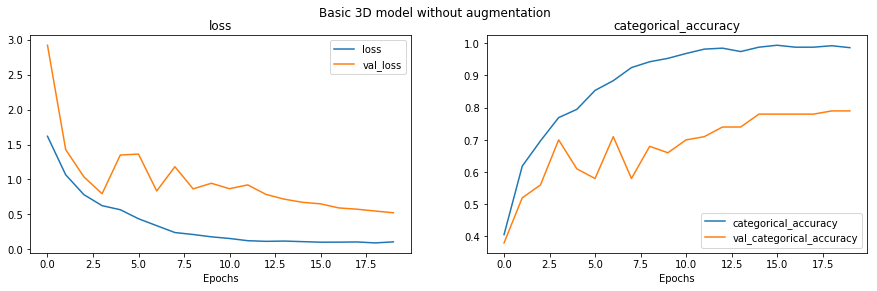

In [23]:
plot_metrics(models['3d_basic_no_augment'], title='Basic 3D model without augmentation')

### Experiment 2 - Basic 3D Model with augmentation level 1

In [26]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 120
image_width = 120
batch_size = 40
num_epochs = 20

models['3d_basic_l1_augment'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), m3d,
                                             optimizers.Adam(), num_epochs, augment_level = 1, nworkers = 8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_14 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 60, 60, 32)     128       
__________

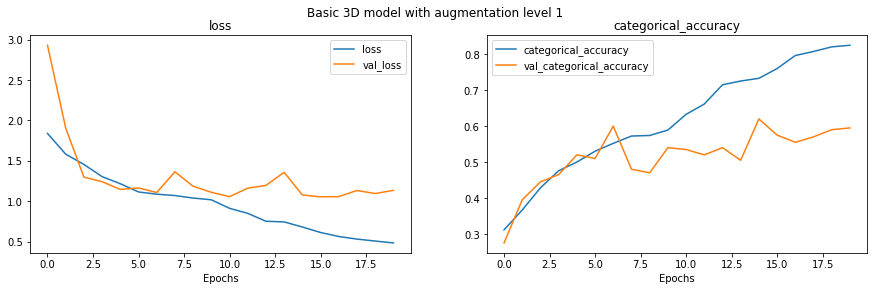

In [27]:
plot_metrics(models['3d_basic_l1_augment'], title='Basic 3D model with augmentation level 1')

From the plots, we can see that there is no improvement in accuracy on either training or validation sets. This model is not useful.

### Experiment 3 - Basic 3D model with augmentation level 2

In [28]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 120
image_width = 120
batch_size = 40
num_epochs = 20

models['3d_basic_l2_augment'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), m3d,
                                             optimizers.Adam(), num_epochs, augment_level = 2, nworkers = 8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_17 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_18 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 8, 60, 60, 32)     128       
__________

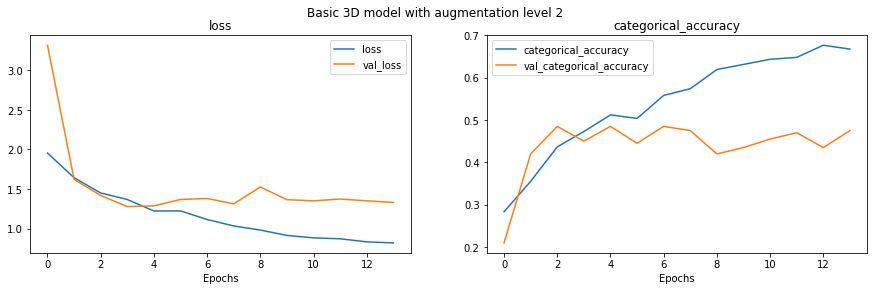

In [29]:
plot_metrics(models['3d_basic_l2_augment'], title='Basic 3D model with augmentation level 2')

From the plots, we can see that, after 12 epochs, there is no significant improvement in validation accuracy. This is a sign of overfitting.

### 3D Model with multiple parameters

In [30]:
def m3d_params(nframes, img_height, img_width, optimizer, dense_neurons = 64, dropout_val = 0.25, disp_summary = False):
    '''
    Static method creates 3D model. 
    The model would contain Three convolution layers followed by a flatten layer and Two Dense layers and softmax layer.
    The kernel sizes are 2x2x2 for all convolution layers with pooling sizes of 2x2x2.
    '''

    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # First convolutional layer
    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # First convolutional layer
    model.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second convolutional layer
    model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third convolutional layer
    model.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # flatten and put a fully connected layer
    model.add(Flatten())

    # Declared fully connected layer with dense neuron = 128
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # Declared fully connected layer with dense neuron = 64
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())
    return model

### Experiment 4 - 3D model with parameters for dense neurons and dropout with no augmentation

In [31]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 160
image_width = 160
batch_size = 40
num_epochs = 20

models['3d_params_dense_dropout_no_aug'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                                        m3d_params, optimizers.Adam(), num_epochs, 
                                                        dense_neurons = 256, dropout_val=0.5, augment_level = 0, nworkers = 8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_21 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
activation_22 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 8, 80, 80, 32)     128       
__________

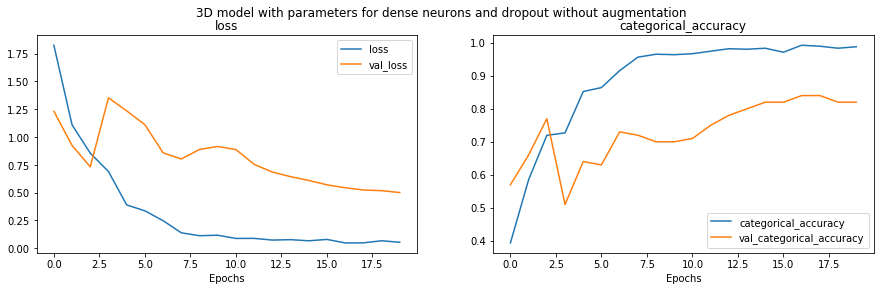

In [32]:
plot_metrics(models['3d_params_dense_dropout_no_aug'], title = '3D model with parameters for dense neurons and dropout without augmentation')

### Experiment 5 - 3D model with parameters for dense neurons and dropout with augmentation level 1

In [33]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 120
image_width = 120
batch_size = 40
num_epochs = 20

models['3d_params_dense_dropout_l1_aug'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                                        m3d_params,
                                                        optimizers.Adam(), num_epochs, dense_neurons = 256, dropout_val=0.5,
                                                        augment_level = 1, nworkers = 8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_25 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_26 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 8, 60, 60, 32)     128       
__________

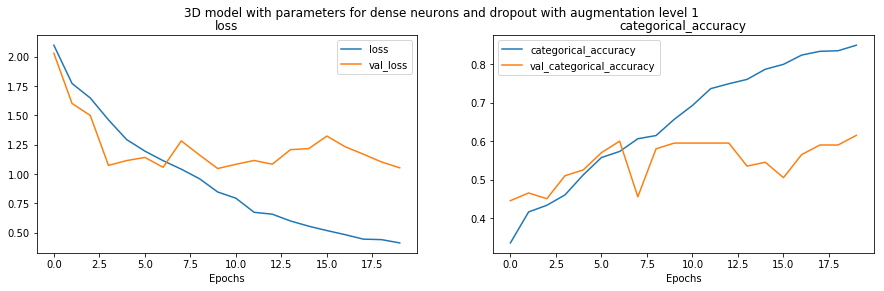

In [34]:
plot_metrics(models['3d_params_dense_dropout_l1_aug'], title = '3D model with parameters for dense neurons and dropout with augmentation level 1')

### Experiment 6 - 3D model with parameters for dense neurons and dropout with augmentation level 2

In [35]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 120
image_width = 120
batch_size = 40
num_epochs = 20

models['3d_params_dense_dropout_l2_aug'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                                        m3d_params,
                                                        optimizers.Adam(), num_epochs, dense_neurons = 256, dropout_val=0.5,
                                                        augment_level = 2, nworkers = 8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_29 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_30 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 8, 60, 60, 32)     128       
__________

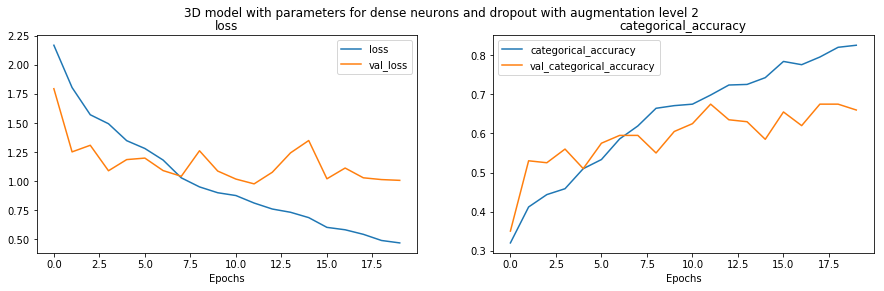

In [36]:
plot_metrics(models['3d_params_dense_dropout_l2_aug'], title = '3D model with parameters for dense neurons and dropout with augmentation level 2')

### Basic 3D model with tanh activation

In [47]:
def m3d_params_tanh(nframes, img_height, img_width, optimizer, dense_neurons = 64, dropout_val = 0.25, disp_summary = False):
    '''
    Static method creates 3D model. 
    The model would contain Three convolution layers followed by a flatten layer and Two Dense layers and softmax layer.
    The kernel sizes are 2x2x2 for all convolution layers with pooling sizes of 2x2x2.
    '''

    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # First convolutional layer
    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', input_shape = input_shape))
    model.add(Activation('tanh'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second convolutional layer
    model.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('tanh'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third convolutional layer
    model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('tanh'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Fourth convolutional layer
    model.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('tanh'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    # flatten and put a fully connected layer
    model.add(Flatten())

    # Declared fully connected layer with dense neuron = 128
    model.add(Dense(dense_neurons, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # Declared fully connected layer with dense neuron = 64
    model.add(Dense(dense_neurons, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())
    return model

### Expriment 7 - 3D Model with tanh activation

In [48]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 160
image_width = 160
batch_size = 40
num_epochs = 20

models['3d_params_tanh_dense_dropout_no_aug'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                                        m3d_params_tanh, optimizers.Adam(), num_epochs,
                                                        dense_neurons = 256, dropout_val=0.5, augment_level = 0, nworkers = 8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_65 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_65 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_87 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_65 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
activation_66 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_88 (Batc (None, 8, 80, 80, 32)     128       
__________

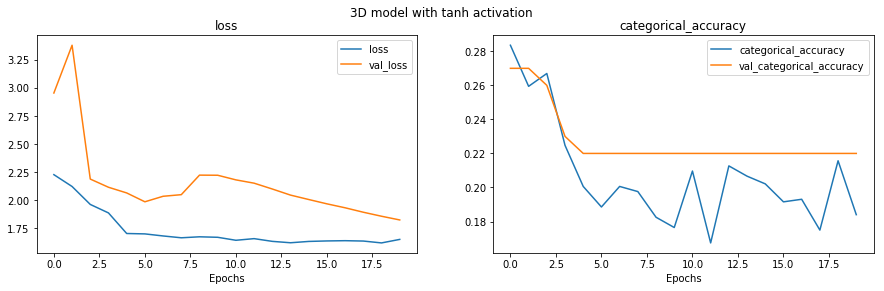

In [49]:
plot_metrics(models['3d_params_tanh_dense_dropout_no_aug'], title = '3D model with tanh activation')

### 3D Model with Leaky Relu activation

In [12]:
def m3d_params_leaky_relu(nframes, img_height, img_width, optimizer, dense_neurons = 64, dropout_val = 0.25, disp_summary = False):
    '''
    Static method creates 3D model. 
    The model would contain Three convolution layers followed by a flatten layer and Two Dense layers and softmax layer.
    The kernel sizes are 2x2x2 for all convolution layers with pooling sizes of 2x2x2.
    '''

    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # First convolutional layer
    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', input_shape = input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second convolutional layer
    model.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third convolutional layer
    model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Fourth convolutional layer
    model.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    # flatten and put a fully connected layer
    model.add(Flatten())

    # Declared fully connected layer with dense neuron = 128
    model.add(Dense(dense_neurons))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # Declared fully connected layer with dense neuron = 64
    model.add(Dense(dense_neurons))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())
    return model

### Experiment 8 - Model with Leaky ReLU activation and without augmentation

In [19]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 160
image_width = 160
batch_size = 40
num_epochs = 20

models['3d_params_leaky_relu_dense_dropout_no_aug'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                                        m3d_params_leaky_relu, optimizers.Adam(), num_epochs,
                                                        dense_neurons = 256, dropout_val=0.5, augment_level = 0, nworkers = 8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 80, 80, 32)     128       
__________

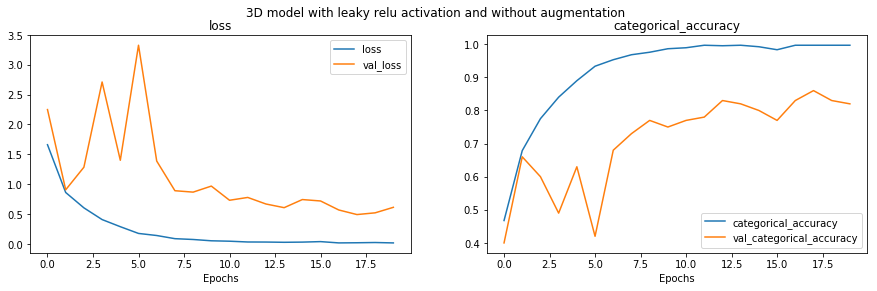

In [20]:
plot_metrics(models['3d_params_leaky_relu_dense_dropout_no_aug'], title = '3D model with leaky relu activation and without augmentation')

### Experiment 9 - Model with Leaky ReLU activation and level 1 augmentation

In [17]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 120
image_width = 120
batch_size = 40
num_epochs = 20

models['3d_params_leaky_relu_dense_dropout_l1_aug'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                                        m3d_params_leaky_relu, optimizers.Adam(), num_epochs,
                                                        dense_neurons = 256, dropout_val=0.5, augment_level = 1, nworkers = 8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 60, 60, 32)     128       
__________

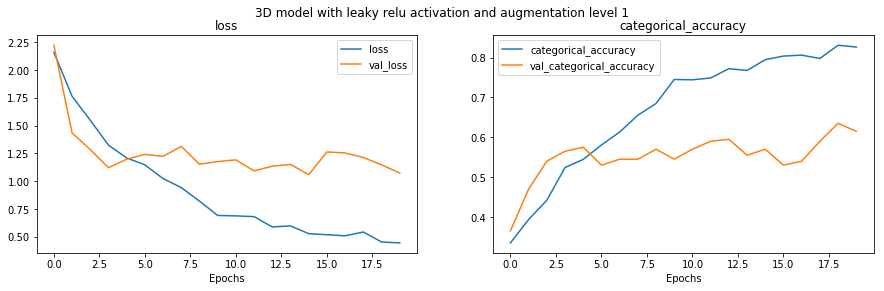

In [18]:
plot_metrics(models['3d_params_leaky_relu_dense_dropout_l1_aug'], title = '3D model with leaky relu activation and augmentation level 1')

In [14]:
def m3d_params_leaky_relu_3layer(nframes, img_height, img_width, optimizer, dense_neurons = 64, dropout_val = 0.25, disp_summary = False):
    '''
    Static method creates 3D model. 
    The model would contain Three convolution layers followed by a flatten layer and Two Dense layers and softmax layer.
    The kernel sizes are 2x2x2 for all convolution layers with pooling sizes of 2x2x2.
    '''

    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # First convolutional layer
    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', input_shape = input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second convolutional layer
    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third convolutional layer
    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # flatten and put a fully connected layer
    model.add(Flatten())

    # Declared fully connected layer with dense neuron = 128
    model.add(Dense(dense_neurons))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # Declared fully connected layer with dense neuron = 64
    model.add(Dense(dense_neurons))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())
    return model

### 3D Model with Leaky ReLU and augmentation level 1 and increased image size

In [15]:
frames = [5,7,11,13,15,17,19,21,23,25] #np.round(np.linspace(0,29,16)).astype(int)
image_height = 160
image_width = 160
batch_size = 40
num_epochs = 20

models['3d_params_leaky_relu_dense_dropout_l1_aug'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                                        m3d_params_leaky_relu_3layer, optimizers.Adam(), num_epochs,
                                                        dense_neurons = 128, dropout_val=0.25, augment_level = 1, nworkers = 8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 10, 160, 160, 16)  1312      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 10, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 5, 80, 80, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 5, 80, 80, 32)     13856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 5, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 80, 80, 32)     128       
__________

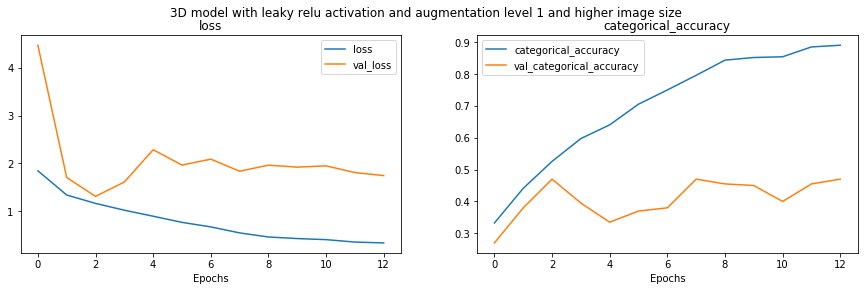

In [16]:
plot_metrics(models['3d_params_leaky_relu_dense_dropout_l1_aug'], title = '3D model with leaky relu activation and augmentation level 1 and higher image size')

In [20]:
frames = [5,6,7,8,11,13,15,17,19,21,23,24,25] #np.round(np.linspace(0,29,16)).astype(int)
image_height = 140
image_width = 140
batch_size = 40
num_epochs = 20

models['3d_params_leaky_relu_incf_l1_aug'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                                        m3d_params_leaky_relu_3layer, optimizers.Adam(), num_epochs,
                                                        dense_neurons = 128, dropout_val=0.25, augment_level = 1, nworkers = 8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 13, 140, 140, 16)  1312      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 13, 140, 140, 16)  0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 13, 140, 140, 16)  64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 6, 70, 70, 16)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 6, 70, 70, 32)     13856     
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 6, 70, 70, 32)     0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 6, 70, 70, 32)     128       
__________

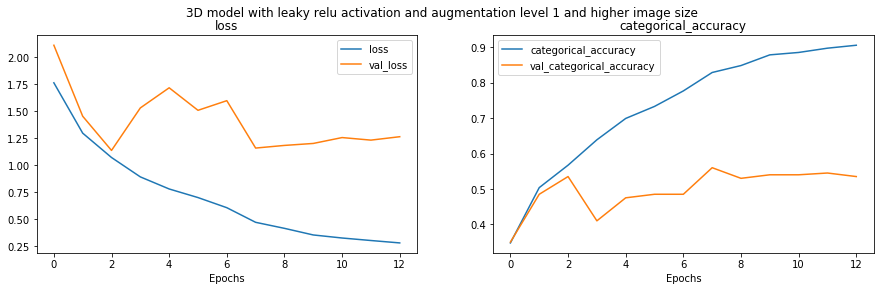

In [21]:
plot_metrics(models['3d_params_leaky_relu_incf_l1_aug'], title = '3D model with leaky relu activation and augmentation level 1 and higher image size')

In [22]:
def m3d_params_leaky_relu_4layer(nframes, img_height, img_width, optimizer, dense_neurons = 64, dropout_val = 0.25, disp_summary = False):
    '''
    Static method creates 3D model. 
    The model would contain Three convolution layers followed by a flatten layer and Two Dense layers and softmax layer.
    The kernel sizes are 2x2x2 for all convolution layers with pooling sizes of 2x2x2.
    '''

    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # First convolutional layer
    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', input_shape = input_shape))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second convolutional layer
    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third convolutional layer
    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    # Third convolutional layer
    model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # flatten and put a fully connected layer
    model.add(Flatten())

    # Declared fully connected layer with dense neuron = 128
    model.add(Dense(dense_neurons))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # Declared fully connected layer with dense neuron = 64
    model.add(Dense(dense_neurons))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())
    return model

In [24]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 130
image_width = 130
batch_size = 40
num_epochs = 20

models['3d_params_leaky_relu_4layer_l1_aug'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                                        m3d_params_leaky_relu_4layer, optimizers.Adam(), num_epochs,
                                                        dense_neurons = 128, dropout_val=0.25, augment_level = 1, nworkers = 8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 16, 130, 130, 16)  1312      
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 16, 130, 130, 16)  0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 16, 130, 130, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 8, 65, 65, 16)     0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 8, 65, 65, 32)     13856     
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 8, 65, 65, 32)     0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 8, 65, 65, 32)     128       
__________

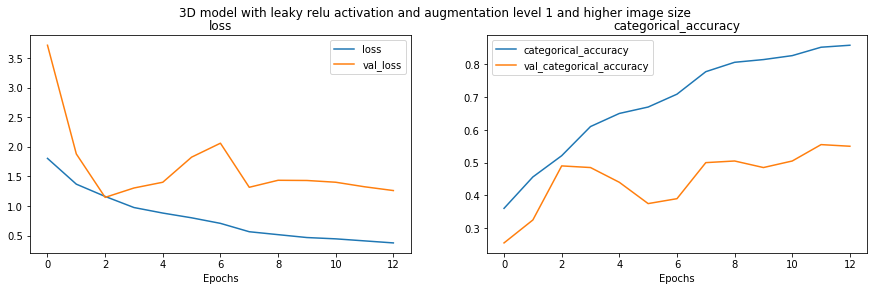

In [25]:
plot_metrics(models['3d_params_leaky_relu_4layer_l1_aug'], title = '3D model with leaky relu activation and augmentation level 1 and higher image size')

In [30]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 130
image_width = 130
batch_size = 40
num_epochs = 20

models['3d_l1_aug_h'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                                        m3d, optimizers.Adam(), num_epochs,
                                                        dense_neurons = 128, dropout_val=0.25, augment_level = 1, nworkers = 8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 16, 130, 130, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 16, 130, 130, 16)  0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 16, 130, 130, 16)  64        
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 8, 65, 65, 16)     0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 8, 65, 65, 32)     13856     
_________________________________________________________________
activation_10 (Activation)   (None, 8, 65, 65, 32)     0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 8, 65, 65, 32)     128       
__________

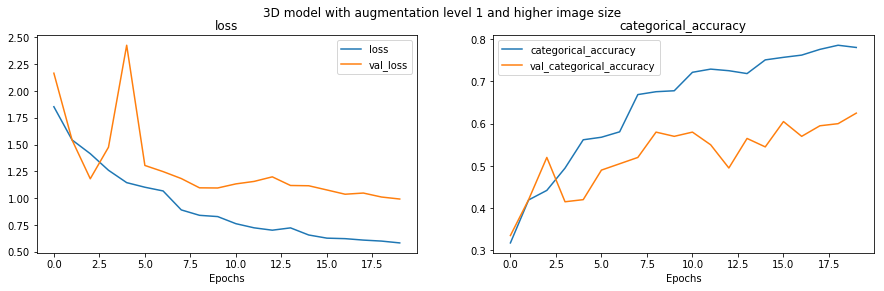

In [31]:
plot_metrics(models['3d_l1_aug_h'], title = '3D model with augmentation level 1 and higher image size')

### 3D Model with Reduced parameters

In [ ]:
def m3d_redparams(nframes, img_height, img_width, optimizer, dense_neurons = 64, dropout_val = 0.25, disp_summary = False):

    '''
    Static method creates 3D model. 
    The model would contain Three convolution layers followed by a flatten layer and Two Dense layers and softmax layer.
    The kernel sizes are 3x3x3 for first convolution layer and 2x2x2 for remaining layers with pooling sizes of 2x2x2.
    '''

    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # First convolutional layer
    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # First convolutional layer
    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second convolutional layer
    model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third convolutional layer
    model.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # flatten and put a fully connected layer
    model.add(Flatten())

    # Declared fully connected layer with dense neuron = 128
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # Declared fully connected layer with dense neuron = 64
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())
    return model


### Experiment 6 - 3D model with reduced parameters and dense neurons and dropout without augmentation

In [33]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 120
image_width = 120
batch_size = 20
num_epochs = 20

models['3d_redparams_dense_dropout_no_aug'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(),
                                                           m3d_redparams,
                                                           optimizers.Adam(), 
                                                           num_epochs, 
                                                           dense_neurons = 256, dropout_val=0.5,
                                                           augment_level = 0, nworkers = 8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_29 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_30 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 8, 60, 60, 32)     128       
__________

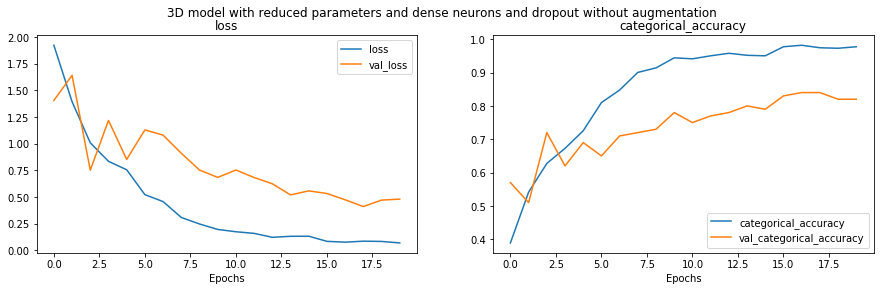

In [34]:
plot_metrics(models['3d_redparams_dense_dropout_no_aug'], title = '3D model with reduced parameters and dense neurons and dropout without augmentation')

### Experiment 7 - 3D model with reduced parameters and dense neurons and dropout with augmentation level 1

In [35]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 120
image_width = 120
batch_size = 20
num_epochs = 20

models['3d_redparams_dense_dropout_l1_aug'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(),
                                                           m3d_redparams,
                                                           optimizers.Adam(), 
                                                           num_epochs, 
                                                           dense_neurons = 256, dropout_val=0.5,
                                                           augment_level = 1, nworkers = 8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_34 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 8, 60, 60, 32)     128       
__________

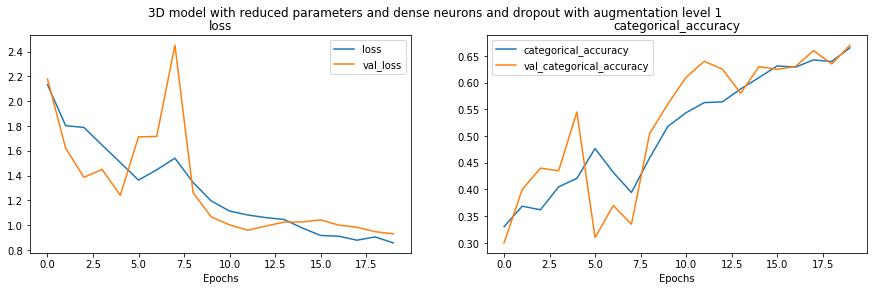

In [36]:
plot_metrics(models['3d_redparams_dense_dropout_l1_aug'], title = '3D model with reduced parameters and dense neurons and dropout with augmentation level 1')

### 3D Model with more layers

In [ ]:
def m3d_more_layer(nframes, img_height, img_width, optimizer, dense_neurons = 64, dropout_val = 0.25, disp_summary = False):
    '''
    Static method creates 3D model. 
    The model would contain Three sets of (Two Convolution layers and max pooling layer) 
                                        followed by a flatten layer and Two Dense layers and softmax layer.
    The kernel sizes are 3x3x3 for all convolution layers with pooling sizes of 2x2x2.
    '''

    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()


    # First convolutional layer
    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # First convolutional layer
    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second convolutional layer
    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third convolutional layer
    model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # flatten and put a fully connected layer
    model.add(Flatten())

    # Declared fully connected layer with dense neuron = 128
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # Declared fully connected layer with dense neuron = 64
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())
    return model

### Experiment 8 - 3D model with multiple layers and dense neurons and dropout with no augmentation

In [37]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 120
image_width = 120
batch_size = 20
num_epochs = 20

models['3d_more_layers_dense_dropout_no_aug'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(),
                                                           m3d_more_layer,
                                                           optimizers.Adam(), 
                                                           num_epochs, 
                                                           dense_neurons = 256, dropout_val=0.5,
                                                           augment_level = 0, nworkers = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_37 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_38 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

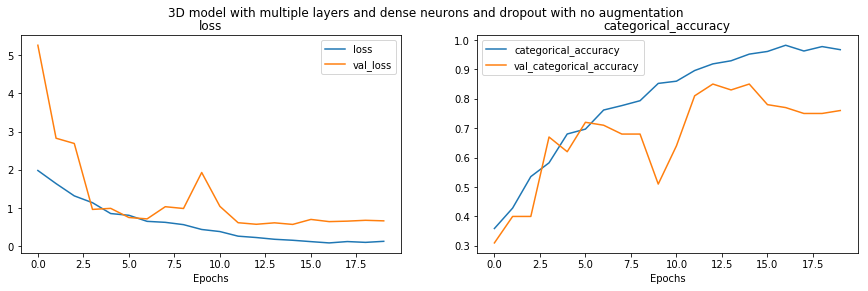

In [38]:
Models.plot_metrics(models['3d_more_layers_dense_dropout_no_aug'], title = '3D model with multiple layers and dense neurons and dropout with no augmentation')

### Experiment 9 - 3D model with multiple layers and dense neurons and dropout with augmentation level 1

In [39]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 120
image_width = 120
batch_size = 20
num_epochs = 20

models['3d_more_layers_dense_dropout_l1_aug'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(),
                                                           m3d_more_layer,
                                                           optimizers.Adam(), 
                                                           num_epochs, 
                                                           dense_neurons = 256, dropout_val=0.5,
                                                           augment_level = 1, nworkers = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_45 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_45 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_63 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_46 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_64 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_41 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

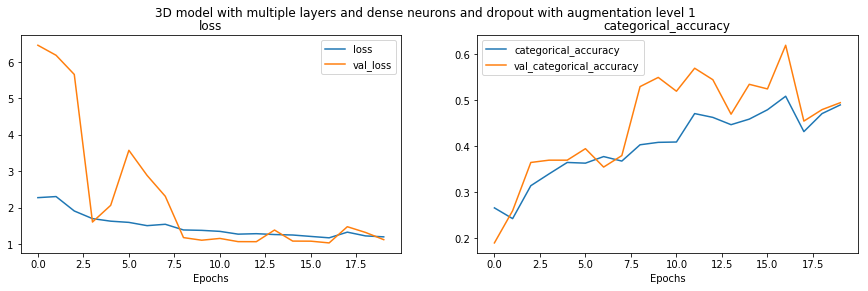

In [40]:
plot_metrics(models['3d_more_layers_dense_dropout_l1_aug'], title = '3D model with multiple layers and dense neurons and dropout with augmentation level 1')

### 3D Model with more dropouts

In [ ]:
def m3d_more_dropouts(nframes, img_height, img_width, optimizer, dense_neurons = 64, dropout_val = 0.25, disp_summary = False):
    '''
    Static method creates 3D model. 
    The model would contain Three sets of (Two Convolution layers, max pooling layer and a dropout) 
                                        followed by a flatten layer and Two Dense layers and softmax layer.
    The kernel sizes are 3x3x3 for all convolution layers with pooling sizes of 2x2x2.
    '''

    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # First convolutional layer
    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout_val))

    # First convolutional layer
    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout_val))

    # Second convolutional layer
    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout_val))

    # Third convolutional layer
    model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout_val))

    # flatten and put a fully connected layer
    model.add(Flatten())

    # Declared fully connected layer with dense neuron = 128
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # Declared fully connected layer with dense neuron = 64
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_val))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())
    return model

### Experiment 10 - 3D model with more dropouts and dense neurons and dropout without augmentation

In [41]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 120
image_width = 120
batch_size = 20
num_epochs = 20

models['3d_more_dropouts_dense_dropout_no_aug'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(),
                                                           m3d_more_dropouts,
                                                           optimizers.Adam(), 
                                                           num_epochs, 
                                                           dense_neurons = 256, dropout_val=0.5,
                                                           augment_level = 0, nworkers = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_53 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_53 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_54 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_74 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

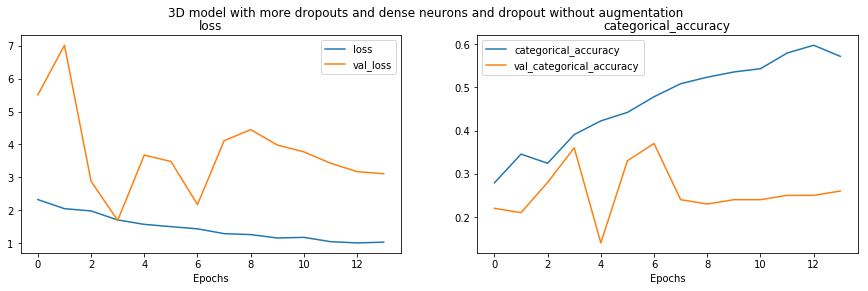

In [42]:
plot_metrics(models['3d_more_dropouts_dense_dropout_no_aug'],title='3D model with more dropouts and dense neurons and dropout without augmentation')

### Experiment 11 - 3D model with more dropouts and dense neurons and dropout with augmentation level 1

In [43]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 120
image_width = 120
batch_size = 20
num_epochs = 20

models['3d_more_dropouts_dense_dropout_l1_aug'] = run_3d_model(batch_size, frames, image_height, image_width, callbacks(),
                                                           m3d_more_dropouts,
                                                           optimizers.Adam(), 
                                                           num_epochs, 
                                                           dense_neurons = 256, dropout_val=0.5,
                                                           augment_level = 1, nworkers = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_61 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_61 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_83 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_62 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_84 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_49 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

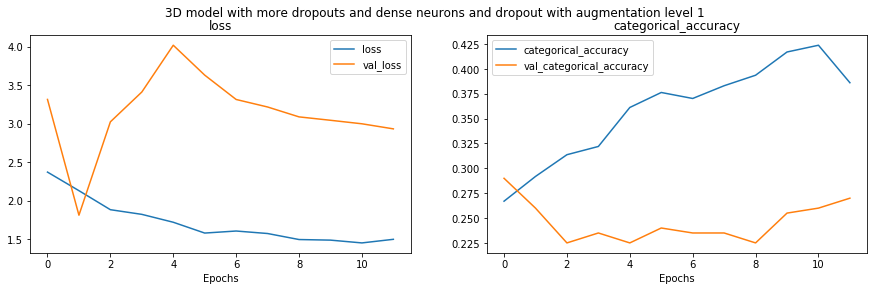

In [44]:
plot_metrics(models['3d_more_dropouts_dense_dropout_l1_aug'],title='3D model with more dropouts and dense neurons and dropout with augmentation level 1')

## 2D Models

In [ ]:
def run_2d_model(batch_size, frames, img_height, img_width, callbacks_list, mdl_fcn, optimizer,
               num_epochs = 15, dense_neurons = 64, rnn_cells = 128, dropout_val = 0.25, augment_level = 0, nworkers = 1):
    '''Construct and run a 2D model. Returns the 2D model after completion of fitting data.
    batch_size: Size of batch for training and validation
    frames: List of frame indices to be used by model
    img_height, img_width: Image dimensions for resizing
    callbacks_list: List of callbacks for model
    mdl_fcn: Model function to build 2D model. Must be one of 2D functions defined under "Models" class
    optimizer: Optimizer to be used by model
    num_epochs: Number of epochs by model
    dense_neurons: Number of dense neurons
    rnn_cells: Number of LSTM/GRU cells.
    dropout_val: Dropout value in 2D model
    augment_level: Augmentation level to be applied on generator. Must be one of {0,1,2}
    nworkers: Number of workers to be configured for fit_generator method.
    '''
    # Configuring trian and validation generator from get_generator function based on batch size and image properties.
    train_generator = Generator(project_folder, 'train', frames, batch_size, img_height, img_width, augment_level)
    val_generator = Generator(project_folder, 'val', frames, batch_size, img_height, img_width, augment_level)
    
    model = mdl_fcn(len(frames), img_height, img_width, optimizer, rnn_cells, dense_neurons = dense_neurons, 
                                                                        dropout_val = dropout_val, disp_summary=True)
    
    model.fit_generator(train_generator.generator(), steps_per_epoch=train_generator.steps, epochs=num_epochs, 
                        verbose=1, validation_data=val_generator.generator(), validation_steps=val_generator.steps, 
                        class_weight=None, workers=nworkers, initial_epoch=0, callbacks = callbacks_list)
    return model

### 2D Model with LSTM cells

In [ ]:
def m2d_lstm(nframes, img_height, img_width, optimizer, rnn_cells = 64, dense_neurons = 64, dropout_val = 0.25, disp_summary=False):
    '''
    Creates Time distributed 2D model.
    The model would contain Four convolution layers  followed by a LSTM layer and dense layers
    The kernel sizes are 3x3 for all convolution layers with pooling sizes of 2x2.
    '''
    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # first convolutional layer
    model.add(TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
                              input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # first convolutional layer
    model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # second convolutional layer
    model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same',activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # third convolutional layer
    model.add(TimeDistributed(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # fourth convolutional layer
    model.add(TimeDistributed(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # flatten and put a fully connected layer
    model.add(TimeDistributed(Flatten()))

    # Declared LSTM layer for RNN model
    model.add(LSTM(rnn_cells))
    model.add(Dropout(dropout_val))

    # Declared fully connected layer
    model.add(Dense(dense_neurons, activation='relu')) 
    model.add(Dropout(dropout_val))

    # Defined softmax layer to classfify the model
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())

    return model

### Experiment 12 - 2D model with LSTM and without augmentation

In [46]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 160
image_width = 160
batch_size = 20
num_epochs = 20
lstm_cells = 128

models['2d_model_lstm_no_aug'] = run_2d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                              m2d_lstm, optimizers.Adam(),
                                              num_epochs, dense_neurons = 256, 
                                              rnn_cells = lstm_cells, 
                                              dropout_val = 0.25, 
                                              augment_level = 0, nworkers = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 16, 160, 160, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 160, 160, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 80, 80, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 80, 80, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 80, 80, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 40, 40, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 16, 40, 40, 64)    18496     
__________

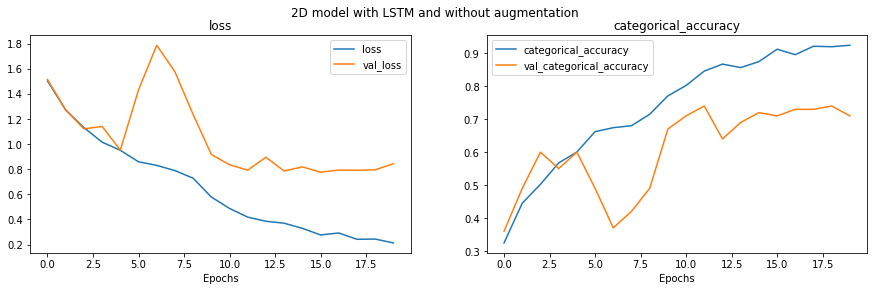

In [47]:
plot_metrics(models['2d_model_lstm_no_aug'], title = '2D model with LSTM and without augmentation')

### Experiment 13 - 2D model with LSTM and with augmentation level 1

In [ ]:
frames = np.round(np.linspace(0,29,16)).astype(int)
image_height = 160
image_width = 160
batch_size = 20
num_epochs = 20
lstm_cells = 128

models['2d_model_lstm_l1_aug'] = run_2d_model(batch_size, frames, image_height, image_width, callbacks(), 
                                              m2d_lstm, optimizers.Adam(),
                                              num_epochs, dense_neurons = 256, 
                                              rnn_cells = lstm_cells, 
                                              dropout_val = 0.25, 
                                              augment_level = 1, nworkers = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 16, 160, 160, 16)  448       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 160, 160, 16)  64        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 80, 80, 16)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 80, 80, 32)    4640      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 16, 80, 80, 32)    128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 16, 40, 40, 32)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 16, 40, 40, 64)    18496     
__________

In [ ]:
plot_metrics(models['2d_model_lstm_l1_aug'], title = '2D model with LSTM and with augmentation level 1')

### 2D Model with GRU

In [ ]:
def m2d_gru(nframes, img_height, img_width, optimizer, rnn_cells = 64, dense_neurons = 64, dropout_val = 0.25, disp_summary=False):
    '''
    Creates Time distributed 2D model.
    The model would contain Four convolution layers  followed by a GRU layer and dense layers
    The kernel sizes are 3x3 for all convolution layers with pooling sizes of 2x2.
    '''
    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    # Initializing Sequential Model
    model = Sequential()

    # first convolutional layer
    model.add(TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
                              input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # first convolutional layer
    model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # second convolutional layer
    model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same',activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # third convolutional layer
    model.add(TimeDistributed(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # fourth convolutional layer
    model.add(TimeDistributed(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # flatten and put a fully connected layer
    model.add(TimeDistributed(Flatten()))

    # Declared LSTM layer for RNN model
    model.add(GRU(rnn_cells))
    model.add(Dropout(dropout_val))

    # Declared fully connected layer
    model.add(Dense(dense_neurons, activation='relu')) 
    model.add(Dropout(dropout_val))

    # Defined softmax layer to classfify the model
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())

    return model

### Experiment 14 - 2D GRU Model without augmentation

In [7]:
## TBD

## Transfer learning models

# Model - Transfer Learning (MobileNet)
Transfer learning has the benefit of decreasing the training time for a neural network model and can result in lower generalization error.
- Transfer learning involves using models trained on one problem as a starting point on a related problem.
- Transfer learning is flexible, allowing the use of pre-trained models directly, as feature extraction preprocessing, and integrated into entirely new models. 
- Keras provides convenient access to many top performing models on the ImageNet image recognition tasks such as VGG, Inception, and ResNet.

Current case study, we are using MobileNet application for transfer learning.

In [ ]:
def run_tl_model(batch_size, frames, img_height, img_width, callbacks_list, mdl_fcn, optimizer, mobilenet_transfer,
               num_epochs = 15,  rnn_cells = 128, dense_neurons = 64, dropout_val = 0.25, augment_level = 0, nworkers = 1):
    '''Construct and run a 2D model with transfer learning. Returns the 2D model after completion of fitting data.
    batch_size: Size of batch for training and validation
    frames: List of frame indices to be used by model
    img_height, img_width: Image dimensions for resizing
    callbacks_list: List of callbacks for model
    mdl_fcn: Model function to build 2D model. Must be one of 2D functions defined under "Models" class
    optimizer: Optimizer to be used by model
    mobilenet_transfer: Model to use as base for transfer learning
    num_epochs: Number of epochs by model
    dense_neurons: Number of dense neurons
    rnn_cells: Number of LSTM/GRU cells.
    dropout_val: Dropout value in 2D model
    augment_level: Augmentation level to be applied on generator. Must be one of {0,1,2}
    nworkers: Number of workers to be configured for fit_generator method.
    '''
    # Configuring trian and validation generator from get_generator function based on batch size and image properties.
    train_generator = Generator(project_folder, 'train', frames, batch_size, img_height, img_width, augment_level)
    val_generator = Generator(project_folder, 'val', frames, batch_size, img_height, img_width, augment_level)
        
    model = mdl_fcn(len(frames), img_height, img_width, optimizer, mobilenet_transfer, rnn_cells, dense_neurons, 
                                                            dropout_val, True)
    
    model.fit_generator(train_generator.generator(), steps_per_epoch=train_generator.steps, epochs=num_epochs, 
                        verbose=1, validation_data=val_generator.generator(), validation_steps=val_generator.steps, 
                        class_weight=None, workers=nworkers, initial_epoch=0, callbacks = callbacks_list)
    
    return model

### 2D Transfer learning model with LSTM

In [ ]:
def m2d_tl_lstm(nframes, img_height, img_width, optimizer, mobilenet_transfer, rnn_cells=128, dense_neurons = 128, 
                                                                   dropout_val = 0.25, disp_summary=False):
    '''
    Creates Time distributed 2D model using transfer learning from mobilenet model.
    The model would contain Four convolution layers  followed by a LSTM layer and dense layers
    The kernel sizes are 3x3 for all convolution layers with pooling sizes of 2x2.
    '''
    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))

    for layer in model.layers:
        layer.trainable = False

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(rnn_cells))
    model.add(Dropout(dropout_val))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout_val))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())

    return model

### Experiment N - 2D Transfer learning Model with LSTM

In [8]:
## TBD

### 2D Transfer learning model with GRU

In [20]:
def m2d_tl_gru(nframes, img_height, img_width, optimizer, mobilenet_transfer, rnn_cells=128, dense_neurons = 128, 
                                                                   dropout_val = 0.25, disp_summary=False):
    '''
    Creates Time distributed 2D model using transfer learning from mobilenet model.
    The model would contain Four convolution layers  followed by a GRU layer and dense layers
    The kernel sizes are 3x3 for all convolution layers with pooling sizes of 2x2.
    '''
    num_classes = 5
    # Declaring input shape for model building.
    input_shape = (nframes, img_height, img_width, 3)

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(rnn_cells))
    model.add(Dropout(dropout_val))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout_val))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.build()

    if disp_summary: print (model.summary())

    return model

### Experiment N - 2D Transfer learning model with GRU